In [1]:
#TF enrichment analysis in ES-specific and constitutive loops in batch
# different from previous version in that, print non-significant loops rather than all loops
import matplotlib.pyplot as plt


In [42]:
# Fisher's extact test p value calculation for constitutive, ES-specific, and constitutive plus ES-specific loops
def fishertestALL(a1,a,A1,A,b1,b):# a - total constitutive, A - total ES-specific, b - total background loops (non-significant loops)
    import scipy.stats as stats
    a2=a-a1
    A2=A-A1
    b2=b-b1
    Alt='greater'
    oddsratio_c, pvalue_c = stats.fisher_exact([[a1, a2], [b1, b2]],alternative=Alt)#constitutive
    oddsratio_e, pvalue_e = stats.fisher_exact([[A1, A2], [b1, b2]],alternative=Alt)#ES-specfic
    oddsratio_s, pvalue_s = stats.fisher_exact([[a1+A1, a2+A2], [b1, b2]],alternative=Alt)#const + ES-specific
    
    return pvalue_c, pvalue_e, pvalue_s, a1/a,A1/A,b1/b # p value and percentage

In [4]:
# Plot fold change 
def plotfoldchange(a1,a2,a3,a4,a5,a6,\
                  b1,b2,b3,b4,b5,b6,\
                  c1,c2,c3,c4,c5,c6,\
                  d1,d2,d3,d4,d5,d6,\
                  title):
    
    #calcualte p value and percentage
    p0_c,p0_e,p0_s,zero_c,zero_e,zero_b=fishertestALL(a1,a2,a3,a4,a5,a6)  # greater than zero
    p1_c,p1_e,p1_s,one_c,one_e,one_b=fishertestALL(b1,b2,b3,b4,b5,b6)  # greater than 1
    p2_c,p2_e,p2_s,two_c,two_e,two_b=fishertestALL(c1,c2,c3,c4,c5,c6)  # greater than 2
    p3_c,p3_e,p3_s,three_c,three_e,three_b=fishertestALL(d1,d2,d3,d4,d5,d6)  # greater than 3
    
    #plot percentage ratio
    plt.plot([">0",">1",">2",">3"], [zero_c/zero_b,one_c/one_b,two_c/two_b,three_c/three_b], 'bo-',\
         label="constitutive")
    plt.plot([">0",">1",">2",">3"], [zero_e/zero_b,one_e/one_b,two_e/two_b,three_e/three_b], 'ro-',\
         label="ES-specific")
    plt.annotate("p=%.2e"%p0_c, xy=(">0", zero_c/zero_b), xytext=(0, zero_c/zero_b)) #5f changed to 2e
    plt.annotate("p=%.2e"%p1_c, xy=(">0", one_c/one_b), xytext=(1, one_c/one_b))
    plt.annotate("p=%.2e"%p2_c, xy=(">0", two_c/two_b), xytext=(2, two_c/two_b))
    plt.annotate("p=%.2e"%p3_c, xy=(">0", three_c/three_b), xytext=(3, three_c/three_b))

    plt.annotate("p=%.2e"%p0_e, xy=(">0", zero_e/zero_b), xytext=(0, zero_e/zero_b))
    plt.annotate("p=%.2e"%p1_e, xy=(">0", one_e/one_b), xytext=(1, one_e/one_b))
    plt.annotate("p=%.2e"%p2_e, xy=(">0", two_e/two_b), xytext=(2, two_e/two_b))
    plt.annotate("p=%.2e"%p3_e, xy=(">0", three_e/three_b), xytext=(3, three_e/three_b))

    plt.ylabel("Fold Enrichment")
    plt.title(title)
    plt.legend()

    plt.show()
    

In [5]:
#Count the number of loops that contain ">n" TF summits
def CountLoops(loops,summits,n):
    '''input file: 1 text file of 5C regions with two sets of primer ID and coordinates in one line
    (corresponding to one loop) and distance in the last column,
1 bed files from macs2 summits. Count the total number of macs2 summits in the loop.
Count the number of 5C loops that contain more than n summits.'''
    table1=[]  # For loops (constitutive, ES-specific, etc)
    with open(loops,'r') as file1:
        for line in file1:
            linetemp=line.split()
            chrom=linetemp[1]
            a1=linetemp[2]
            a2=linetemp[3]
            a3=linetemp[6]
            a4=linetemp[7]
            distance=linetemp[8]
            table1.append([chrom, (int(a1),int(a2), linetemp[0],int(a3),int(a4), linetemp[4],distance)]) 
            #count1+=1

    table2=[] # For TF summits 
    with open(summits,'r') as file2:
        for line in file2:
            linetemp=line.split()
            chrom=linetemp[0]
            b1=linetemp[1]
            b2=linetemp[2]
            table2.append([chrom, (int(b1), int(b2))])
            #count2 += 1

    dict1={}
    dict2={}
    for key, val in table1:
        dict1.setdefault(key,[]).append(val)
    for key, val in table2:
        dict2.setdefault(key,[]).append(val)

    count=0
    for chrom1 in dict1:
        for c1 in dict1[chrom1]:
            localcount1=0 # set the number of count for this particular looping to 0.
            localcount2=0
            if chrom1 not in list(dict2.keys()):
                continue
            for c2 in dict2[chrom1]:
                if c1[1]>c2[0] and c1[0]<c2[1]:  # Fprimer range
                    localcount1 +=1
                    #out_f.write('%s\t%s\t%s\t%s\t%s\t%s\t%s\n' %(chrom1, c1[2],c1[0],c1[1],c1[5],c1[3],c1[4]))
                elif c1[4]>c2[0] and c1[3]<c2[1]: # Rprimer range
                    localcount2+=1
                    #out_f.write('%s\t%s\t%s\t%s\t%s\t%s\t%s\n' %(chrom1, c1[2],c1[0],c1[1],c1[5],c1[3],c1[4]))
            if localcount1+localcount2>n:
                #out_f.write('%s\t%s\t%s\t%s\t%s\n' %(c1[2],localcount1,c1[5],localcount2, c1[6]))
                count+=1
    #print("%s loops have more than %s occupied sites." %(count,ARG))
    #print("accounting for %.1f%% of %s counts in %s" %((float(count)/count1*100),count1,options.filename1))
    return count

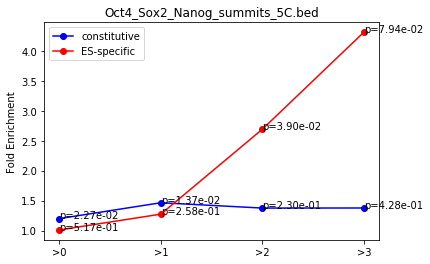

,# of ES-specific loops,# of ES-specific loops containing target,# of constitive loops,# of constitive loops containing target,# of non-significant loops,# of non-significant loops containing target
>0,83,25,260,93,86424,25770
>1,83,10,260,36,86424,8173
>2,83,5,260,8,86424,1934
>3,83,2,260,2,86424,483


In [30]:
#Do analysis within all loops
import pandas as pd
from IPython.display import display
loops=["non-significant_loops_length_and_coordinates.txt","constitutive_loops_length_and_coordinates.txt",\
         "mES_specific_loops_length_and_coordinates.txt"]
#summits=["Oct4_Sox2_Nanog_common_with_Klf4_summits_5C.bed"]
summits=["Oct4_Sox2_Nanog_summits_5C.bed"]
#"Oct4_Sox2_Nanog_common_with_Med12_p8_Smc1_p8_not_Ctcf_p4_summits_5C.bed"
#"Esrrb_Klf4_common_summits_5C.bed","Esrrb_Med12_p4_common_summits.bed","Esrrb_Med12_p8_common_summits.bed","Esrrb_Med12_p8_not_Ctcf_p4_summits_5C.bed"
#"Oct4_Klf4_common_summits_5C.bed","Oct4_Med12_p4_common_summits.bed","Oct4_Med12_p8_common_summits.bed","Oct4_Med12_p8_not_Ctcf_p4_summits_5C.bed"
#summits=["Sox2_Med12_p4_common_summits.bed","Sox2_Med12_p8_common_summits.bed","Sox2_Med12_p8_not_Ctcf_p4_summits_5C.bed"]

M=[86424,86424,86424,86424,260,260,260,260,83,83,83,83]# total loops: non-significant, constutive, ES-specific
for s in summits:
    N=[]
    for l in loops:
        for n in range(0,4):
            N.append(CountLoops(l,s,n))
    df=pd.DataFrame({'# of constitive loops containing target':N[4:8],\
                    '# of constitive loops ':M[4:8],\
                    '# of ES-specific loops containing target':N[8:12],\
                    '# of ES-specific loops':M[8:12],\
                    '# of non-significant loops containing target':N[0:4],\
                    '# of non-significant loops':M[0:4]})
    df.index=['>0','>1','>2','>3']
    plotfoldchange(N[4],M[4],N[8],M[8],N[0],M[0],\
              N[5],M[5],N[9],M[9],N[1],M[1],\
              N[6],M[6],N[10],M[10],N[2],M[2],\
              N[7],M[7],N[11],M[11],N[3],M[3],\
              s)
    display(df)

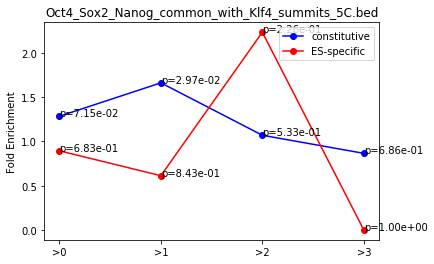

,# of ES-specific loops,# of ES-specific loops not containing target at all,# of constitive loops,# of constitive loops not containing target at all,# of non-significant loops,# of non-significant loops not containing target at all
>0,83,8,260,36,86424,9315
>1,83,2,260,17,86424,3399
>2,83,2,260,3,86424,932
>3,83,0,260,1,86424,384


In [43]:
#Do analysis within all loops, but plot for not containing
import pandas as pd
import numpy as np
from IPython.display import display
loops=["non-significant_loops_length_and_coordinates.txt","constitutive_loops_length_and_coordinates.txt",\
         "mES_specific_loops_length_and_coordinates.txt"]
summits=["Oct4_Sox2_Nanog_common_with_Klf4_summits_5C.bed"]
summit0='Oct4_Sox2_Nanog_summits_5C.bed'
M=[86424,86424,86424,86424,260,260,260,260,83,83,83,83] # total loops: non-significant, constutive, ES-specific

# for summit0
L=[]
for l in loops:
    for n in range(0,4):
        L.append(CountLoops(l,summit0,n))
L=np.array(L)      

for s in summits:
    N=[]
    for l in loops:
        for n in range(0,4):
            N.append(CountLoops(l,s,n))
    N=np.array(N)
    df=pd.DataFrame({'# of constitive loops not containing target at all':L[4:8]-N[4:8],\
                    '# of constitive loops ':M[4:8],\
                    '# of ES-specific loops not containing target at all':L[8:12]-N[8:12],\
                    '# of ES-specific loops':M[8:12],\
                    '# of non-significant loops not containing target at all':L[0:4]-N[0:4],\
                    '# of non-significant loops':M[0:4]})
    df.index=['>0','>1','>2','>3']
    plotfoldchange(L[4]-N[4],M[4],L[8]-N[8],M[8],L[0]-N[0],M[0],\
              L[5]-N[5],M[5],L[9]-N[9],M[9],L[1]-N[1],M[1],\
              L[6]-N[6],M[6],L[10]-N[10],M[10],L[2]-N[2],M[2],\
              L[7]-N[7],M[7],L[11]-N[11],M[11],L[3]-N[3],M[3],\
              s)
    display(df)

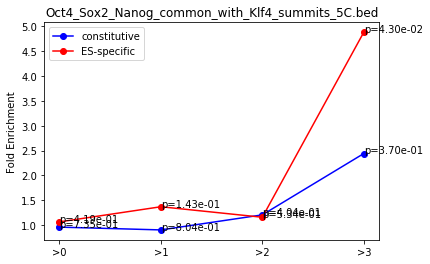

,# of ES-specific loops,# of ES-specific loops containing target,# of constitive loops,# of constitive loops containing target,# of non-significant loops,# of non-significant loops containing target
>0,25,17,93,57,25770,16455
>1,10,8,36,19,8173,4774
>2,5,3,8,5,1934,1002
>3,2,2,2,1,483,99


In [22]:
#Do analysis within certain-TF-containing loops
import pandas as pd
from IPython.display import display
loops=["non-significant_loops_length_and_coordinates.txt","constitutive_loops_length_and_coordinates.txt",\
         "mES_specific_loops_length_and_coordinates.txt"]
summits=["Oct4_Sox2_Nanog_common_with_Klf4_summits_5C.bed"]

#"Oct4_Sox2_Nanog_common_with_Med12_p8_Smc1_p8_not_Ctcf_p4_summits_5C.bed"
summit0="Oct4_Sox2_Nanog_summits_5C.bed"
#"Esrrb_Klf4_common_summits_5C.bed","Esrrb_Med12_p4_common_summits.bed","Esrrb_Med12_p8_common_summits.bed","Esrrb_Med12_p8_not_Ctcf_p4_summits_5C.bed"
#"Oct4_Klf4_common_summits_5C.bed","Oct4_Med12_p4_common_summits.bed","Oct4_Med12_p8_common_summits.bed","Oct4_Med12_p8_not_Ctcf_p4_summits_5C.bed"
#summits=["Sox2_Med12_p4_common_summits.bed","Sox2_Med12_p8_common_summits.bed","Sox2_Med12_p8_not_Ctcf_p4_summits_5C.bed"]
#summit0="Sox2_summits_5C.bed"
M=[]
for l in loops:
    for n in range(0,4):
        M.append(CountLoops(l,summit0,n))
#print(M)

for s in summits:
    N=[]
    for l in loops:
        for n in range(0,4):
            N.append(CountLoops(l,s,n))
    df=pd.DataFrame({'# of constitive loops containing target':N[4:8],\
                    '# of constitive loops ':M[4:8],\
                    '# of ES-specific loops containing target':N[8:12],\
                    '# of ES-specific loops':M[8:12],\
                    '# of non-significant loops containing target':N[0:4],\
                    '# of non-significant loops':M[0:4]})
    df.index=['>0','>1','>2','>3']
    plotfoldchange(N[4],M[4],N[8],M[8],N[0],M[0],\
              N[5],M[5],N[9],M[9],N[1],M[1],\
              N[6],M[6],N[10],M[10],N[2],M[2],\
              N[7],M[7],N[11],M[11],N[3],M[3],\
              s)
    display(df)

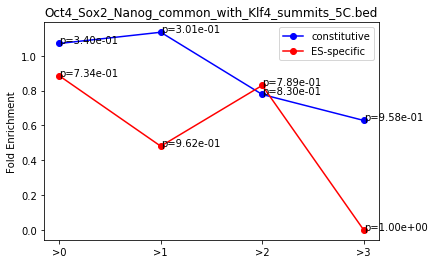

,# of ES-specific loops,# of ES-specific loops not containing target at all,# of constitive loops,# of constitive loops not containing target at all,# of non-significant loops,# of non-significant loops not containing target at all
>0,25,8,93,36,25770,9315
>1,10,2,36,17,8173,3399
>2,5,2,8,3,1934,932
>3,2,0,2,1,483,384


In [26]:
#Do analysis within certain-TF-containing loops, but plot for "not containing"
import pandas as pd
import numpy as np
from IPython.display import display
loops=["non-significant_loops_length_and_coordinates.txt","constitutive_loops_length_and_coordinates.txt",\
         "mES_specific_loops_length_and_coordinates.txt"]
summits=["Oct4_Sox2_Nanog_common_with_Klf4_summits_5C.bed"]
summit0="Oct4_Sox2_Nanog_summits_5C.bed"

M=[]
for l in loops:
    for n in range(0,4):
        M.append(CountLoops(l,summit0,n))
M=np.array(M)
for s in summits:
    N=[]
    for l in loops:
        for n in range(0,4):
            N.append(CountLoops(l,s,n))
    N=np.array(N)
    df=pd.DataFrame({'# of constitive loops not containing target at all':M[4:8]-N[4:8],\
                    '# of constitive loops ':M[4:8],\
                    '# of ES-specific loops not containing target at all':M[8:12]-N[8:12],\
                    '# of ES-specific loops':M[8:12],\
                    '# of non-significant loops not containing target at all':M[0:4]-N[0:4],\
                    '# of non-significant loops':M[0:4]})
    df.index=['>0','>1','>2','>3']
    plotfoldchange(M[4]-N[4],M[4],M[8]-N[8],M[8],M[0]-N[0],M[0],\
              M[5]-N[5],M[5],M[9]-N[9],M[9],M[1]-N[1],M[1],\
              M[6]-N[6],M[6],M[10]-N[10],M[10],M[2]-N[2],M[2],\
              M[7]-N[7],M[7],M[11]-N[11],M[11],M[3]-N[3],M[3],\
              s)
    display(df)


In [10]:
import numpy as np
matrix=np.zeros((4,6))
matrix[:,0]=N[4:8]
matrix

array([[ 57.,   0.,   0.,   0.,   0.,   0.],
       [ 19.,   0.,   0.,   0.,   0.,   0.],
       [  5.,   0.,   0.,   0.,   0.,   0.],
       [  1.,   0.,   0.,   0.,   0.,   0.]])